# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rich_clust


In [2]:
import os
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2
import natsort

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools

In [3]:
params = {
    'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
    'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
    'pathSuffixToStat': 'plane1/stat.npy',
    'pathSuffixToOps': 'plane1/ops.npy',
    'pref_use_NN_distances': True,
    'use_GPU': True,
    'pref_blurROIs': True,
    'params_blur': {
        'kernel_size': 7, # Edge length of kernel image. Make odd number.
        'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
    },
    'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
    'params_dIOU': {
        'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
        'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
    }
}

In [4]:
dir_github = Path(params['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing, pickle_helpers

In [10]:
%load_ext autoreload
%autoreload 2
from registration_rClust import data_importing, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import paths

In [6]:
def print_list(l):
    for item in l:
        print(item)

In [7]:
dir_allOuterFolders = Path(params['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(path_helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['pathSuffixToStat']
pathSuffixToOps = params['pathSuffixToOps']

paths_allStat = [path / pathSuffixToStat for path in dir_allS2pFolders]
paths_allOps  = [path / pathSuffixToOps for path in dir_allS2pFolders]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D7
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Vale

# Import data

In [9]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36, 36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Imported 14 stat files into class as self.statFiles. Total number of ROIs: 37061. Number of ROI from each file: [2451, 2798, 2656, 2865, 2349, 2926, 2527, 2055, 4600, 2735, 2740, 1915, 2286, 2158]


100%|███████████████████████████████████████████| 14/14 [00:01<00:00, 10.99it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Imported 14 spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


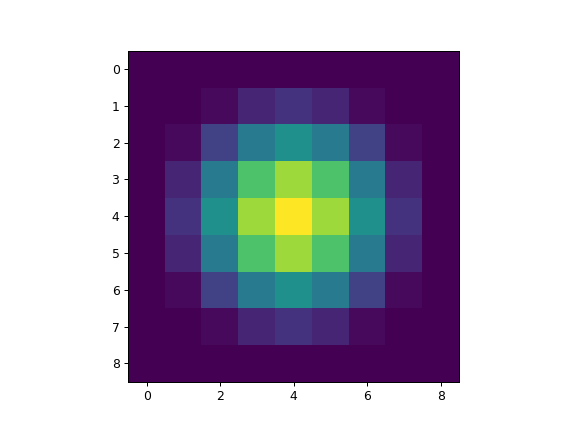

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [30]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [17]:
%load_ext autoreload
%autoreload 2
from registration_rClust import alignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

<IPython.core.display.Javascript object>


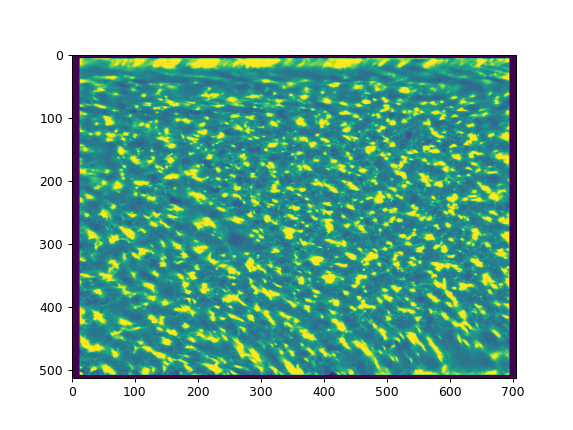

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


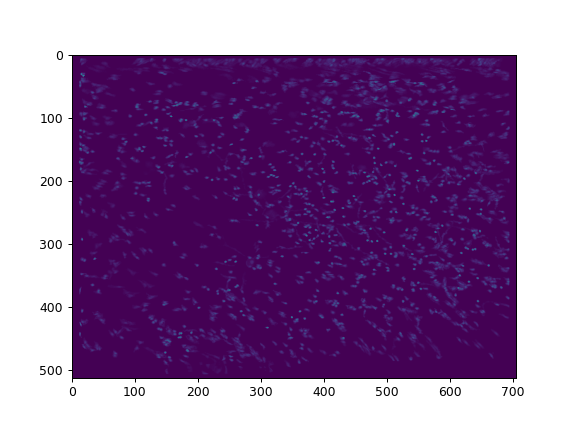

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [29]:
%matplotlib notebook

visualization.display_toggle_image_stack(aligner.FOVs_aligned)

visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

Check to make sure the FOVs look aligned

In [13]:
# display_toggle_image_stack(FOVs_aligned, clim=None)

In [14]:
# display_toggle_image_stack([rois.multiply( rois.max(1).power(-1) ).sum(0).reshape(frame_height, frame_width) for rois in ROIs_aligned], clim=None)

In [15]:
# display_toggle_2channel_image_stack(flows, clim=(-20,20))

## Blur ROIs (optional)

In [217]:
%load_ext autoreload
%autoreload 2
from registration_rClust import blurring

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


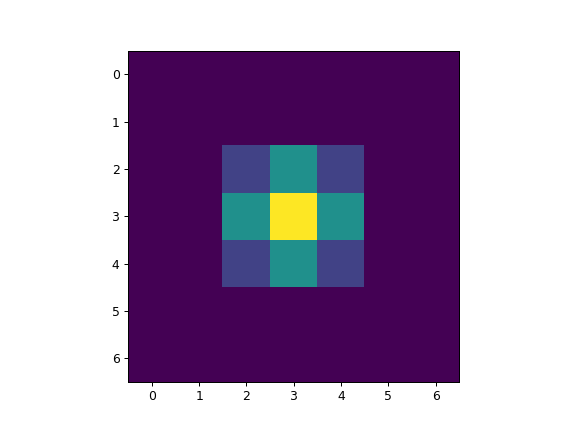

In [218]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2.0,
    device='cuda:0',
    plot_kernel=True
)

In [219]:
blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=100,
);

<IPython.core.display.Javascript object>


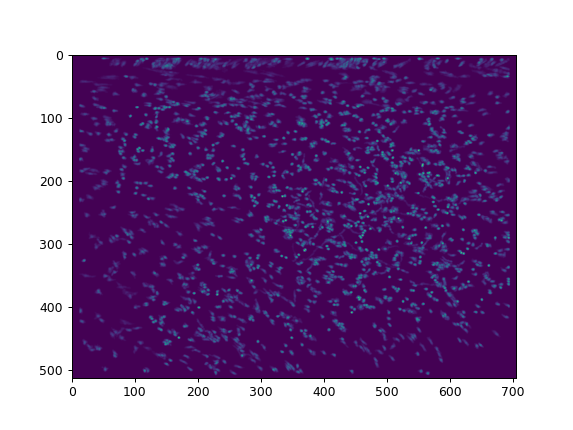

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [224]:
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [17]:
# display_toggle_image_stack([ROIs.sum(0).reshape(frame_height, frame_width) for ROIs in ROIs_aligned_blur]) if pref_blurROIs else None

## Neural network embedding distances

In [7]:
pref_use_NN_distances = True

## NN fileNames
fileName_NN_pth = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth' # name of pth file in dir_NNmodels directory
fileName_NN_py  = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient' # EXCLUDE THE .PY AT THE END. name of py file in dir_NNmodels directory.

## Directories of Classifier stuff
dir_GRC_repo = dir_github / 'GCaMP_ROI_classifier'
dir_GRC_EndUser = dir_GRC_repo / 'End_User'
dir_NNmodels = dir_GRC_EndUser / 'simclr-models'
dir_GRC_util = dir_GRC_repo / 'new_stuff'

## Paths to NN and LR classifiers
path_NN_pth = dir_NNmodels / fileName_NN_pth
path_NN_py = dir_NNmodels / fileName_NN_py

display(path_NN_pth)
display(path_NN_py)

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient.pth')

PosixPath('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/End_User/simclr-models/ResNet18_simCLR_model_202112078_EOD_transfmod=efficient')

In [8]:
import sys
sys.path.append(str(dir_NNmodels))
sys.path.append(str(dir_github))
sys.path.append(str(dir_GRC_util))
sys.path.append(str(dir_GRC_EndUser))

# %load_ext autoreload
# %autoreload 2
import util
import simclr_helpers

In [ ]:

print(f"starting: downloading network from {params['gdriveID_networkFiles']}")
import gdown
gdown.download_folder(id=params['gdriveID_networkFiles'], output=dir_save_network_files, quiet=True, use_cookies=False)
sys.path.append(dir_save_network_files)
import model
print(f"completed: downloading network")

path_state_dict = str(Path(dir_save_network_files).resolve() / params['fileName_state_dict'])
path_nnTraining = str(Path(dir_save_network_files).resolve() / params['fileName_params_nnTraining'])
# path_model = str(Path(dir_save_network_files).resolve() / params['fileName_model'])
path_classifier = str(Path(dir_save_network_files).resolve() / params['fileName_classifier'])


In [18]:
sf_all_cropped = util.import_multiple_stat_files(
    paths_statFiles=paths_allStat, 
#     dir_statFiles=None,
#     fileNames_statFiles=None,
    out_height_width=[36,36], 
    max_footprint_width=801, 
    plot_pref=False
)

In [19]:
device_model = torch_helpers.set_device(use_GPU=params['use_GPU'])

model, model_module = import_pth_model(path_NN_pth, fileName_NN_py)

data = np.concatenate(sf_data.images, axis=0)

if pref_use_NN_distances:
    # Create Data Sets / Data Loaders
    dataset, dataloader = model_module.get_dataset_dataloader(data, batch_size=64, device=device_model) ## TODO: Troubleshoot the runtime on this

    # Get Model Latents
    latents = simclr_helpers.dataloader_to_latents(dataloader, model.to(device_model), DEVICE=device_model)
    
else:
    latents = None

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/580 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %250 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)


In [20]:
del model

gc.collect()

torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [21]:
device_model = torch_helpers.set_device(use_GPU=params['use_GPU'])

scattering = Scattering2D(J=2, L=8, shape=sf_data.images[0].shape[-2:])
if params['use_GPU']:
    scattering = scattering.cuda()

latents_swt = torch.cat([get_latents_swt(sfs, scattering, device_model).cpu() for sfs in sf_data.images], axis=0)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


## Embed ROIs in t-SNE space

In [22]:
sfs = scipy.sparse.vstack(ROIs_aligned_blur)
sfs = sfs.power(params['mask_power'])
sfs = sfs.multiply( 0.5 / sfs.sum(1))
sfs = scipy.sparse.csr_matrix(sfs)

In [23]:
distances_IOU = sklearn.neighbors.NearestNeighbors(
        algorithm=params['params_dIOU']['algorithm'],
        leaf_size=30, 
        metric='manhattan',
        p=1,
    #     metric_params=None, 
        n_jobs=-1
    ).fit(sfs).kneighbors_graph(
        sfs,
        n_neighbors=params['params_dIOU']['n_neighbors'] if params['params_dIOU']['n_neighbors'] != 'full' else sfs.shape[0],
        mode='distance'
    )

In [24]:
distances_NN = torch.cdist(latents, latents, p=2)

In [25]:
distances_swt = torch.cdist(latents_swt, latents_swt, p=2)

In [26]:
s_IOU = 1 - distances_IOU.todense()
s_IOU[s_IOU < 0] = 0

s_IOU[range(s_IOU.shape[0]), range(s_IOU.shape[0])] = 0
s_IOU = torch.as_tensor(s_IOU, dtype=torch.float32)

In [27]:
s_NN = 1 / (distances_NN / distances_NN.max())
s_NN[s_NN < 0] = 0
s_NN[range(s_NN.shape[0]), range(s_NN.shape[0])] = 0

In [28]:
s_swt = 1 / (distances_swt / distances_swt.max())
s_swt[s_swt < 0] = 0
s_swt[range(s_swt.shape[0]), range(s_swt.shape[0])] = 0

In [29]:
session_bool = torch.as_tensor(np.vstack([np.array([indexing.idx2bool(i_sesh, length=n_sessions)]*sesh.shape[0]) for i_sesh, sesh in enumerate(ROIs_aligned)]), device='cpu', dtype=torch.float32)
s_sesh = torch.logical_not((session_bool @ session_bool.T).type(torch.bool))

In [30]:
s_conj = s_IOU * s_NN * s_swt * s_sesh

In [31]:
s_conj[s_conj < 1e-5] = 0

In [32]:
d_conj = 1 / s_conj

In [33]:
# d_conj[np.isinf(d_conj).type(torch.bool)] = 0  ## convert inf to 0 so they sparsen out
d_conj[np.isinf(d_conj).type(torch.bool)] = 10000  ## convert inf to 0 so they sparsen out

d_conj = torch.maximum( d_conj, d_conj.T )  ## force symmetry
d_conj[np.arange(d_conj.shape[0]), np.arange(d_conj.shape[0])] = 0

d_conj = scipy.sparse.csr_matrix(d_conj.numpy())  ## sparsen

In [34]:
d = d_conj.todense()
# d = distances_IOU.todense()

link_methods = ['single', 'complete', 'ward', 'average']
# link_methods = ['average']
links = {method : scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(d), method=method) for method in tqdm(link_methods)}

  0%|          | 0/4 [00:00<?, ?it/s]

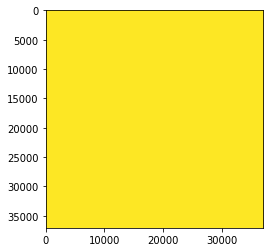

In [35]:
plt.figure()
plt.imshow(d, vmax=1)

In [36]:
def display_clustering_widget(
    embeddings, 
    min_samples, 
    max_samples=None,
    min_slider=0.01,
    max_slider=5, 
    start_slider=1.0,
    single_color=False,
    ):

    from ipywidgets import interact, widgets
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=10)
    # sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

    def get_val_counts(vals):
        vals_unique = np.unique(vals)
        vals_counts = np.zeros_like(vals, dtype=np.int64)
        for ii, val in enumerate(vals_unique):
            vals_counts[vals==val] = np.sum(vals==val)
        return vals_counts
    def update(t=1):
        t_toUse = t/10000
        
#         # Compute DBSCAN
#         db = sklearn.cluster.DBSCAN(
#             eps=eps_toUse,
#             min_samples=min_samples, 
#     #         metric='manhattan',
#             metric_params=None, 
#             algorithm='auto',
#             leaf_size=30, 
#             p=2, 
#             n_jobs=-1
#         ).fit(embeddings)

#         labels = db.labels_
#     #     labels = db.labels_ - db.labels_.min()
    
        labels = scipy.cluster.hierarchy.fcluster(links['average'], t=t_toUse, criterion='distance')
        
        if max_samples is not None:
            labels[get_val_counts(labels) > max_samples] = -1

        if single_color:
            cmap = rand_cmap(2, verbose=False)
        else:
            cmap = rand_cmap(len(np.unique(labels)), verbose=False)

        if len(np.unique(labels)) == 1:
            print('Eps value gives one big cluster. Adjust')
        else:
            sc.set_color(cmap(squeeze_integers(labels)+1))

            fig.canvas.draw_idle()
            ax.set_title(f'eps={round(t_toUse,3)}, n_clusters={len(np.unique(labels))}')
            print(np.unique(labels))

    interact(update, t=widgets.IntSlider(min=min_slider, max=max_slider, step=1, value=start_slider));
#     interact(update, t=widgets.IntSlider(min=0, max=200, step=1, value=1));
    

rand_cmap = plotting_helpers.rand_cmap
squeeze_integers = classification.squeeze_integers

In [37]:
cmap = plotting_helpers.rand_cmap(nlabels=d.shape[0], verbose=False)

# c_labels = cmap(tuple(torch.linspace(0.,1., len(labels))))

In [67]:
meds = np.concatenate(sf_data.get_midCoords())

<IPython.core.display.Javascript object>


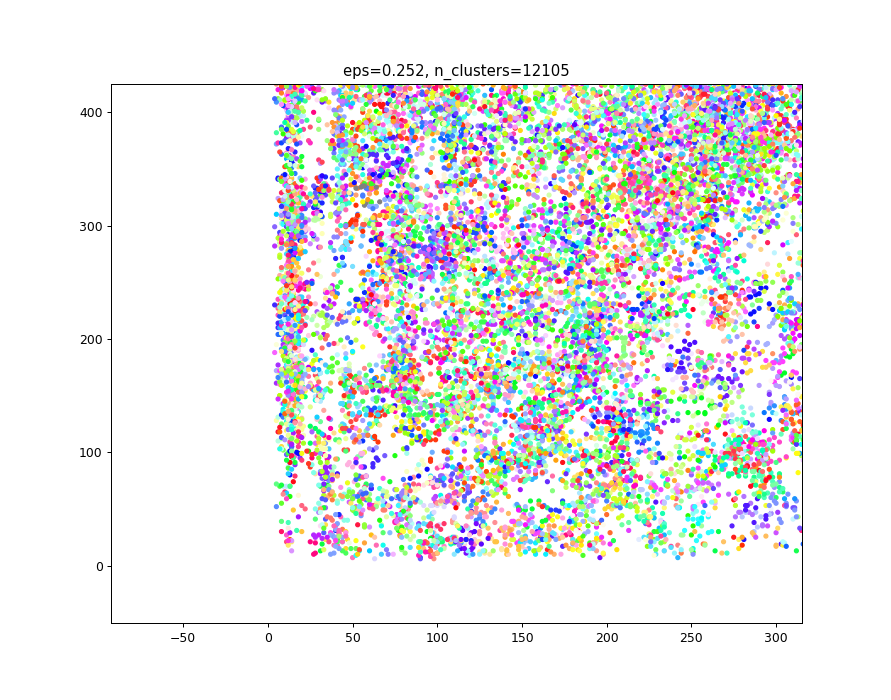

interactive(children=(IntSlider(value=1, description='t', max=20000), Output()), _dom_classes=('widget-interac…

In [47]:
%matplotlib notebook

display_clustering_widget(
    embeddings=meds, 
    min_samples=2, 
    max_samples=None,
    min_slider=0,
    max_slider=20000, 
    start_slider=1,
    single_color=False,
    )

In [49]:
sweep_t_vals = math_functions.bounded_logspace(0.1, 1.50, 50)

In [50]:
def _labels_to_idx(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return [np.where(labels==label)[0] for label in np.unique(labels)]

def _labels_to_bool(labels):
#     return {label: np.where(labels==label)[0] for label in np.unique(labels)}
    return np.array([labels==label for label in np.unique(labels)])

def _freq_of_values(vals):
    u = np.unique(vals)
    f = np.array([np.sum(vals==unique) for unique in u])
    return np.array([f[u==val][0] for val in vals])




cluster_idx = []
for ii, t in tqdm(enumerate(sweep_t_vals)):
    [cluster_idx.append(scipy.sparse.csr_matrix(_labels_to_bool(scipy.cluster.hierarchy.fcluster(links[method], t=t, criterion='distance')))) for method in link_methods]
cluster_idx = scipy.sparse.vstack(cluster_idx)

0it [00:00, ?it/s]

In [51]:
def hash_matrix(x):
    y = np.array(np.packbits(x.todense(), axis=1))
    return np.array([hash(tuple(vec)) for vec in y])

In [52]:
# batch_size = 1000
# l = cluster_idx.shape[0]
# clusterHashes = np.concatenate([hash_matrix(batch) for batch in tqdm(indexing.make_batches(cluster_idx[:l], batch_size=batch_size, length=l), total=l/batch_size)], axis=0).shape

clusterHashes = np.concatenate(parallel_helpers.multiprocessing(hash_matrix, indexing.make_batches(cluster_idx, batch_size=100, length=cluster_idx.shape[0]), workers=32), axis=0)

In [53]:
# clusterHashes_block = [hash(tuple(vec)) for vec in cluster_idx]
# u, idx, c = np.unique(
#     ar=clusterHashes_block,
#     return_index=True,
#     return_counts=True,
# )

u, idx, c = np.unique(
    ar=clusterHashes,
    return_index=True,
    return_counts=True,
)

# clusters_idx_unique, clusters_idx_unique_freq = np.unique(cluster_idx, axis=0, return_counts=True)

clusters_idx_unique = cluster_idx[idx]
clusters_idx_unique_freq = c

In [54]:
min_samples = 2
max_samples = n_sessions

# sizes_clusters_raw = np.array([len(idx) for idx in clusters_idx_unique], dtype=np.int64)
sizes_clusters_raw = clusters_idx_unique.sum(1)
# print(clusters_idx_unique)

bool_tooSmall = (sizes_clusters_raw < min_samples).astype(np.bool8)
bool_tooBig = (sizes_clusters_raw > max_samples).astype(np.bool8)

idx_toDelete = np.array(bool_tooSmall + bool_tooBig).squeeze()

## remove clusters with too few samples
clusters_idx_unique = clusters_idx_unique[np.logical_not(idx_toDelete),:]
clusters_idx_unique_freq = clusters_idx_unique_freq[np.logical_not(idx_toDelete)]

# clusters_idx_unique = np.delete(clusters_idx_unique, idx_toDelete)
# clusters_idx_unique_freq = np.delete(clusters_idx_unique_freq, idx_toDelete)

In [55]:
h_raw = torch.stack([torch.as_tensor(indexing.idx2bool(idx.toarray().squeeze(), length=n_roi_all), dtype=torch.float32) for idx in clusters_idx_unique], dim=0).T.type(torch.bool)

In [ ]:
# c_score = clustering.cluster_similarity_score(s_conj**2, h_raw.type(torch.float32), method_in='mean', method_out='mean')
c_score = clustering.cluster_similarity_score(s_conj, h_raw, method_in='min', method_out='max')

In [ ]:
plt.figure()
plt.imshow(
#     c_score[:200, :200]*torch.logical_not(torch.eye(200)), 
    c_score[:1000, :1000], 
    aspect='auto',
    vmax=10
)

In [ ]:
c_sil = clustering.cluster_silhouette_score(s_conj, h_raw)

In [ ]:
# c_sil_norm = math_functions.generalised_logistic_function(torch.log(c_sil), mu=0.5)**1
c_sil_norm = c_sil

In [ ]:
c_redundant = ( (torch.einsum('ab, ac, bd -> cd', torch.eye(h_raw.shape[0], dtype=torch.float32), h_raw.type(torch.float32), h_raw.type(torch.float32))>0) * (torch.logical_not(torch.eye(h_raw.shape[1]))) ).type(torch.bool)

In [ ]:
w_raw = (((h_raw.cpu().sum(0) / n_sessions)**1) * (c_sil_norm.cpu()**1) * (clusters_idx_unique_freq / clusters_idx_unique_freq.max())**1)**1

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(w_raw.cpu())
# plt.ylim([0,1.1])
axs[1].plot(w_raw.cpu())
axs[1].set_yscale('log')

In [ ]:
idx_c_good = (w_raw>1e-6)
idx_c_good.sum() / w_raw.shape[0]

In [ ]:
DEVICE = 'cuda:0'

# c = (c_max*1 + c_mean*1)/2 + c_redundant*0
c = copy.copy(c_score)[idx_c_good][:,idx_c_good]

# c = c_max + c_redundant*1
# c = c_local*1
# c = c_sum
# c = c_mean
# c = c_local
# c = c_sum + c_redundant*2

h = copy.copy(h_raw)[:, idx_c_good]

w = w_raw[idx_c_good]

crc = clustering.Constrained_rich_clustering(
    c,
    h,
    w,
    device=DEVICE,
    m_init=(torch.ones(c.shape[0])*-5 + torch.rand(c.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-4, max_lr=1e0, step_size_up=1000, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e0,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e-4,
    maskL1_penalty=0e-2,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [ ]:
crc.fit(
    min_iter=1e3,
    max_iter=2e5,
    verbose=True, 
    verbose_interval=50
)

In [ ]:
crc.plot_loss()

In [ ]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

In [ ]:
crc.plot_clusterWeights()

In [ ]:
crc.plot_sampleWeights()

In [ ]:
crc.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

In [ ]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = crc.predict(m_threshold=m_threshold)

In [ ]:
m_bool.sum()

In [ ]:
fig, axs = crc.plot_labelCounts()
axs[0].set_ylim([0,20])

In [ ]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [ ]:
colors = cmap(preds / preds.max())
colors[...,:3] *= confidence.numpy()[:,None]
# colors[...,:3] *= ((scores_samples / scores_samples.max()).numpy()**0.3)[:,None]

plt.figure()
plt.scatter(meds[:,0], meds[:,1], s=10, c=colors)

In [ ]:
plt.figure()
plt.hist(confidence);

In [ ]:
plt.figure()
plt.hist(confidence[preds>=0]);

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

In [ ]:
cmap = plotting_helpers.rand_cmap(nlabels=int(preds.max()), under=[0,0,0,0.0], verbose=False);
cmap

In [ ]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

In [ ]:
n_planes = n_sessions
labels = classification.squeeze_integers(preds.numpy().astype(np.int64))

labels[(confidence < 0.5).numpy()] = -1
# labels = labels

ucid_toUse = labels
idx_roi_session_toUse = idx_roi_session

colors = sparse.COO(rand_cmap(len(np.unique(ucid_toUse)), verbose=False)(np.int64(ucid_toUse))[:,:3])
# colors *= (1-((scores_samples / scores_samples.max()).numpy())**7)[:,None]
# colors *= (((1/scores_samples) / (1/scores_samples).max()).numpy()**1)[:,None]

plane_oneHot = classification.idx_to_oneHot(idx_roi_session_toUse.astype(np.int32))

ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
ROIs_csr_scaled = ROIs_csr.multiply(ROIs_csr.max(1).power(-1))
ROIs_sCOO = sparse.COO(ROIs_csr_scaled)

def tile_sparse(arr, n_tiles):
    """
    tiles along new (last) dimension
    """
    out = sparse.stack([arr for _ in range(n_tiles)], axis=-1)
    return out

ROIs_tiled = tile_sparse(tile_sparse(ROIs_sCOO, n_planes), 3)

ROIs_colored = ROIs_tiled * colors[:,None,None,:] * plane_oneHot[:,None,:,None]

FOV_ROIs_colored = ROIs_colored.sum(0).reshape((frame_height, frame_width, n_planes, 3)).transpose((2,0,1,3))

In [ ]:
FOV_all_noClip = copy.copy(FOV_ROIs_colored.todense())
FOV_all_noClip[FOV_all_noClip>1] = 1

In [ ]:
image_processing.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
#                                 save_path='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/run_20220403/run_liberal_4to9Sesh.avi'
                           )

In [ ]:
%matplotlib notebook
from ipywidgets import widgets, interact

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0], interpolation='none')

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all_noClip.shape[0]-1, step=1, value=0));

In [ ]:
plt.figure()
plt.imshow(FOV_all_noClip.max(0))

outputs:
`UCIDs`
`UCIDs_bySession`

In [ ]:
## Only need to run this once since it is just pulling from stuff that should be static

ROIs_raw = scipy.sparse.vstack([scipy.sparse.csr_matrix(rois.reshape(rois.shape[0], -1)) for rois in tqdm(sf_all)])

ROIs = {
    "ROIs_aligned": ROIs_aligned,
    "ROIs_raw": ROIs_raw,
    "frame_height": frame_height,
    "frame_width": frame_width,
    "idx_roi_session": idx_roi_session
}

In [ ]:
name_save = os.path.split(dir_allOuterFolders)[-1]

In [ ]:
dir_save = Path(r'/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/4th_email/results/').resolve()

In [ ]:
def get_first_and_last_ROI_idx_from_each_session(ROIs_aligned):
    last_idx = np.cumsum([rois.shape[0] for rois in ROIs_aligned])
    first_idx = np.concatenate(([0], last_idx[:-1]))
    
    return list(first_idx), list(last_idx)

In [ ]:
preds_bySession = [list(preds[ii:jj].numpy().astype(np.int64)) for ii,jj in zip(get_first_and_last_ROI_idx_from_each_session(ROIs_aligned)[0], get_first_and_last_ROI_idx_from_each_session(ROIs_aligned)[1])]

In [ ]:
# pickle_helpers.simple_save(
#     {
#         "UCIDs": list(preds.numpy().astype(np.int64)),
#         "UCIDs_bySession": preds_bySession,
#         "ROIs": ROIs,
#     },
#     filename=dir_save / (name_save + '.plane0.rClust' '.pkl'),
# #     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
# )